In [1]:
import sys
import gymnasium as gym
import numpy as np
from collections import defaultdict

from plot_utils import plot_blackjack_values, plot_policy

np.random.seed(0)

env = gym.make('Blackjack-v1')
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


### Review: Monte Carlo Constant-alpha Control
> short for: MC Control, details see [notebook](../monte-carlo-methods/monte_carlo.ipynb)

Remember that the constant-$\alpha$ MC control algorithm alternates between **policy evaluation** and **policy improvement** steps to recover the optimal policy $\pi_*$ .
$$
\begin{align}
\pi_* = argmax_{\pi}(Q(S_t, A_t)) \\
Q(S_t, A_t) = \mathbb{E}_\pi[G_t \mid S=S_t, A=A_t] = \frac{1}{N}\sum_{0}^{N} G_t \\
\end{align}
$$
In the **policy evaluation** step, the **agent collects an episode** $S_0, A_0, R_0, S_1, \cdots, S_T$ using the most recent policy $\pi$, After the episode finishes, for each time-step $t$, if the corresponding  state-action pair $(S_t, A_t)$ is a first visit, the Q-table is modified using the following **update equation**:
$$
\begin{align}
Q(S_t, A_t) = Q(S_t, A_t) + \alpha (G_t - Q(S_t, A_t)) \\
G_t := \sum_{i=0}^{T}\gamma^i R_{t+i} \\
\end{align}
$$
$G_t$ is the return at timestep $t$, and $Q(S_t, A_t)$ is the entry in the Q-table corresponding to state $S_t$ and action $A_t$

The main idea behind this **update equation** is that $Q(S_t, A_t)$ contains the agent's estimate for the expected return if the environment is in state $S_t$ and the agent selects action $A_t$. Then we push the value of  $Q(S_t, A_t)$ to make it agree slightly more with the return. The magnitude of the change that we make to $Q(S_t, A_t)$ is controlled by the hyperparameter $0<α≤1$.


### TD Control: SARSA

#### Idea

The main darwbacks is that the **agent collects an episode** in the **policy evaluation** step. What if we could update the Q-Table in real-time, without waiting for the entire episode to finish? This approach uses a small time window of information to make updates. By leveraging the current Q-value estimate and **the estimated value of the next state-action pair(lookup the existed Q table to find certain pair), we compute an $G_t$'s alternative estimate**. The Q-value is then adjusted incrementally toward this estimate. This method forms the basis of temporal difference control, which will be explored in greater detail later.

![](./images/td-learning-sarsa.png)

In the algorithm, the number of episodes the agent collects is equal to `num_episodes`. 

For each episode, the agent repeat:
1. Takes the action $A_t$ (from the current state $S_t$) that is $ϵ$-greedy with respect to the Q-table.
2. Receives the reward $R_{t}$ and the next state $S_{t+1}$.
3. Chooses the next action $A_{t+1}$ (from the next state $S_{t+1}$) that is $ϵ$-greedy with respect to the Q-table.
4. Uses the information in the tuple ($S_t$, $A_t$, $R_{t}$, $S_{t+1}$, $A_{t+1}$) to update the entry $Q(S_t, A_t)$ in the Q-table corresponding to the current state $S_t$ and the action $A_t$.

#### Psedocode

> note: we refer $R_{t}$ as $R_{t+1}$ current reward based $S_t$ and $A_t$, just for name convention, so slightly different with below's define.

![](./images/td-learning-sarsa-psedocode.png)




#### Implementation

In [2]:
def epsilon_greedy(actions, epsilon):
    nA = len(actions)
    probs = np.ones(nA) * (epsilon / nA)
    best_action = np.argmax(actions)
    probs[best_action] = 1 - epsilon + (epsilon / nA)
    return probs

In [22]:
def td_control_sarsa(env, num_episodes, alpha, gamma=1.0, eps_decay=0.999, eps_min=0.05):
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = 1.0
    
    for i_episode in range(1, num_episodes+1):
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
            
        epsilon = max(epsilon*eps_decay, eps_min)
        
        # observe S_0
        state, info = env.reset()
        
        # choose action A_0 using policy derived from Q table
        # S_0   --> A_0
        probs = epsilon_greedy(Q[state], epsilon)
        action = np.random.choice(np.arange(nA), p=probs)

        # in an episode
        while True:
            
            # take action A_t and observe R_t, S_t+1
            # A_t   --> R_t, S_t+1
            next_state, reward, done, truncated, info = env.step(action)
            
            # until next_state is terminal
            # reward R_T as final return
            if done:
                Q[state][action] = Q[state][action] + alpha * (reward - Q[state][action])
                break
            
            # choose action A_t+1 using same policy on next state from Q table
            # S_t+1 --> A_t+1 
            next_probs = epsilon_greedy(Q[next_state], epsilon)
            next_action = np.random.choice(np.arange(nA), p=next_probs)

            # update Q table
            G_estimate = reward + gamma * Q[next_state][next_action]
            Q[state][action] = Q[state][action] + alpha * (G_estimate - Q[state][action])

            # update state, action
            state, action = next_state, next_action
    
    # get policy
    policy = {k: np.argmax(v) for k, v in Q.items()}
    return policy, Q

In [23]:
# obtain the estimated optimal policy and action-value function
policy, Q = td_control_sarsa(env, 500000, alpha=0.02, eps_min=0.05)

Episode 500000/500000.

#### Plot

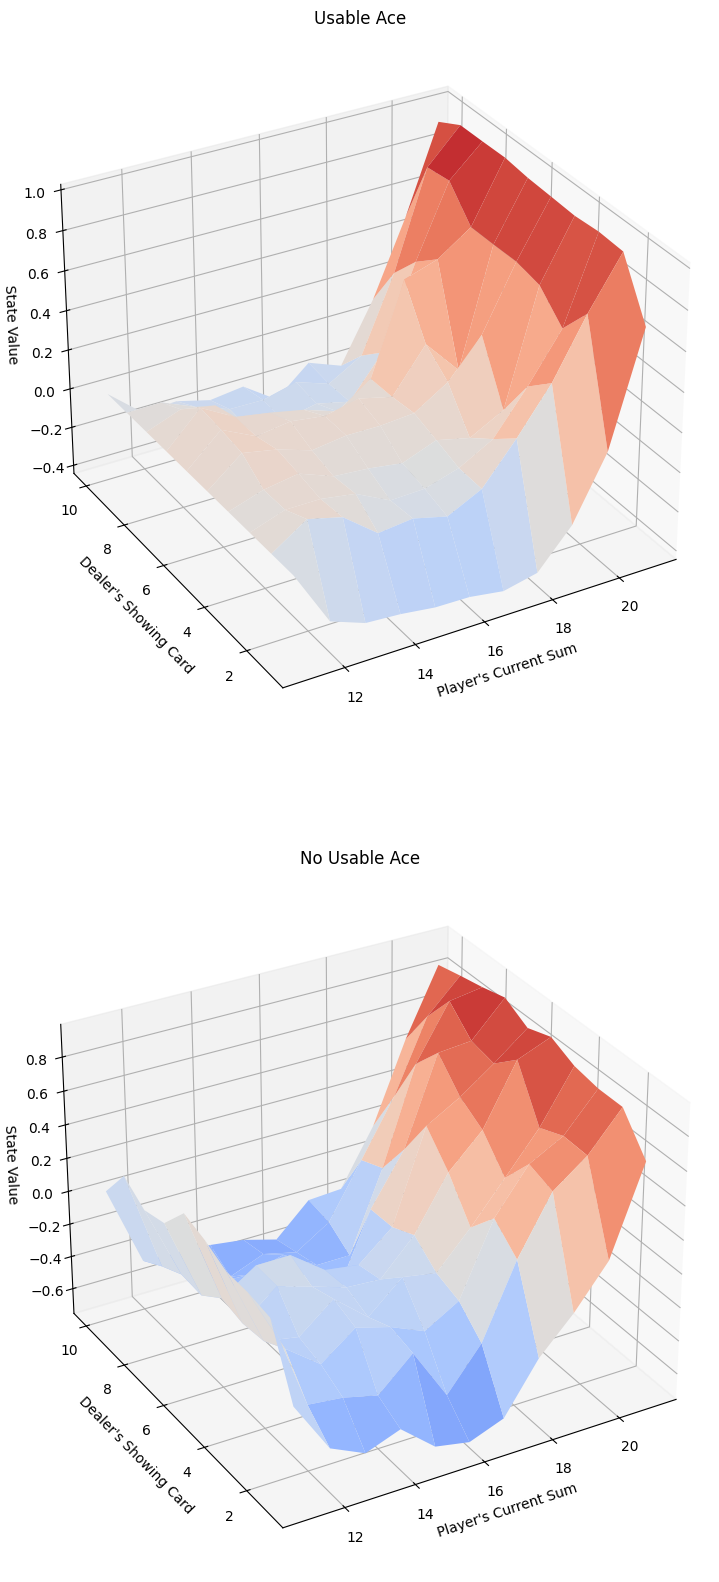

In [24]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

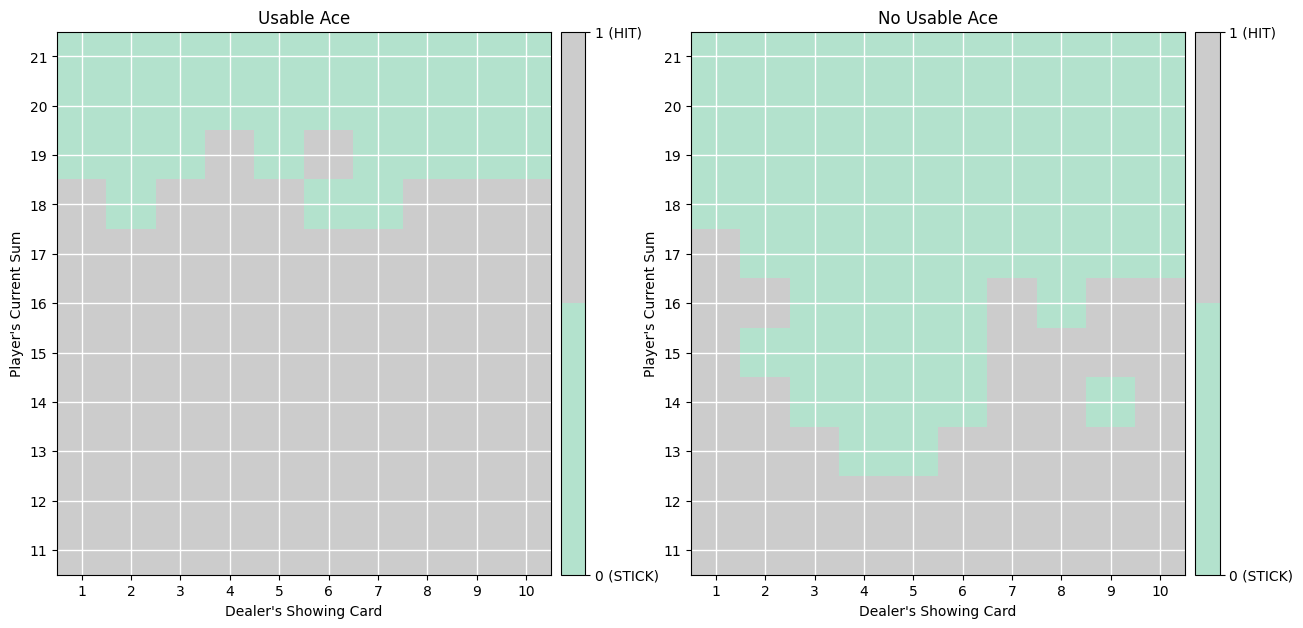

In [25]:
# plot the policy
plot_policy(policy)

### TD Control: SARSA-Max (Q-Learning)

#### Idea

Instead of using the action ($A_{t+1}$) selected by the ε-greedy policy for the update, SARSA-Max uses the **greedy action** (the action that maximizes the Q-value in the next state).

The update formula incorporates the greedy action, which directly approximates the optimal value function:
$$
Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha \left[ R_{t+1} + \gamma \max_{a \in A(s)} Q(S_{t+1}, a) - Q(S_t, A_t) \right]
$$


**Key Differences**:
  - In SARSA, the updates are based on the actions actually experienced by the agent (on-policy).
  - In SARSA-Max, the updates use the greedy action (off-policy), regardless of the action selected by the ε-greedy policy.
  - SARSA pushes the action values closer to evaluating the **ε-greedy policy** being followed by the agent.
  - SARSA-Max directly approximates the **optimal value function** at every time step.

![](./images/sarsamax-or-q-learning.png)


#### Psedocode

> note: we refer $R_{t}$ as $R_{t+1}$ current reward based $S_t$ and $A_t$, just for name convention, so slightly different with below's define.

![](./images/sarsamax-or-q-learning-psedocode.png)

#### Implementation

In [33]:
def td_control_sarsamax(env, num_episodes, alpha, gamma=1.0, eps_decay=0.999, eps_min=0.05):
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = 1.0
    for i_episode in range(1, num_episodes+1):
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        epsilon = max(epsilon*eps_decay, eps_min)
        
        # observe S_0
        state, info = env.reset()
        
        # in an episode
        while True:
            # choose action A_t using policy derived from Q table
            # S_t --> A_t
            probs = epsilon_greedy(Q[state], epsilon)
            action = np.random.choice(np.arange(nA), p=probs)
            
            # take action A_t and observe R_t, S_t+1
            # A_t --> R_t, S_t+1
            next_state, reward, done, truncated, info = env.step(action)
            
            # until next_state is terminal
            # reward R_T as final return
            if done:
                Q[state][action] = Q[state][action] + alpha * (reward - Q[state][action])
                break
                
            # choose best action value in next state from Q table (off-policy)
            # S_t+1 --> max(A_t+1)
            next_action = np.argmax(Q[next_state])
            
            # update Q table using max action value
            G_estimate = reward + gamma * Q[next_state][next_action]
            Q[state][action] = Q[state][action] + alpha * (G_estimate - Q[state][action])
            
            # update state only (no need to update action in Q-learning)
            state = next_state
    
    # get policy
    policy = {k: np.argmax(v) for k, v in Q.items()}
    return policy, Q

#### Plot

In [34]:
# obtain the estimated optimal policy and action-value function
policy, Q = td_control_sarsamax(env, 500000, alpha=0.02, eps_min=0.05)

Episode 500000/500000.

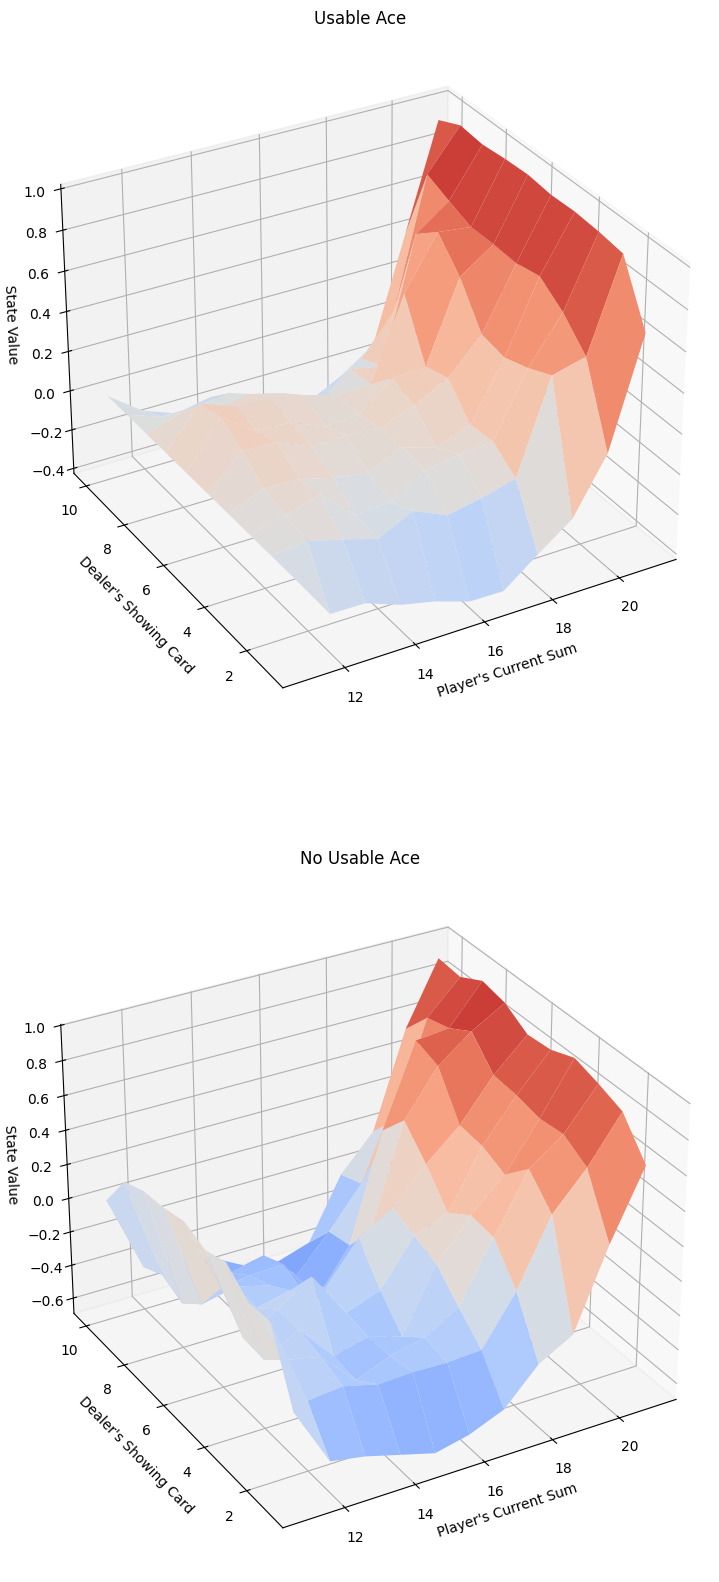

In [35]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

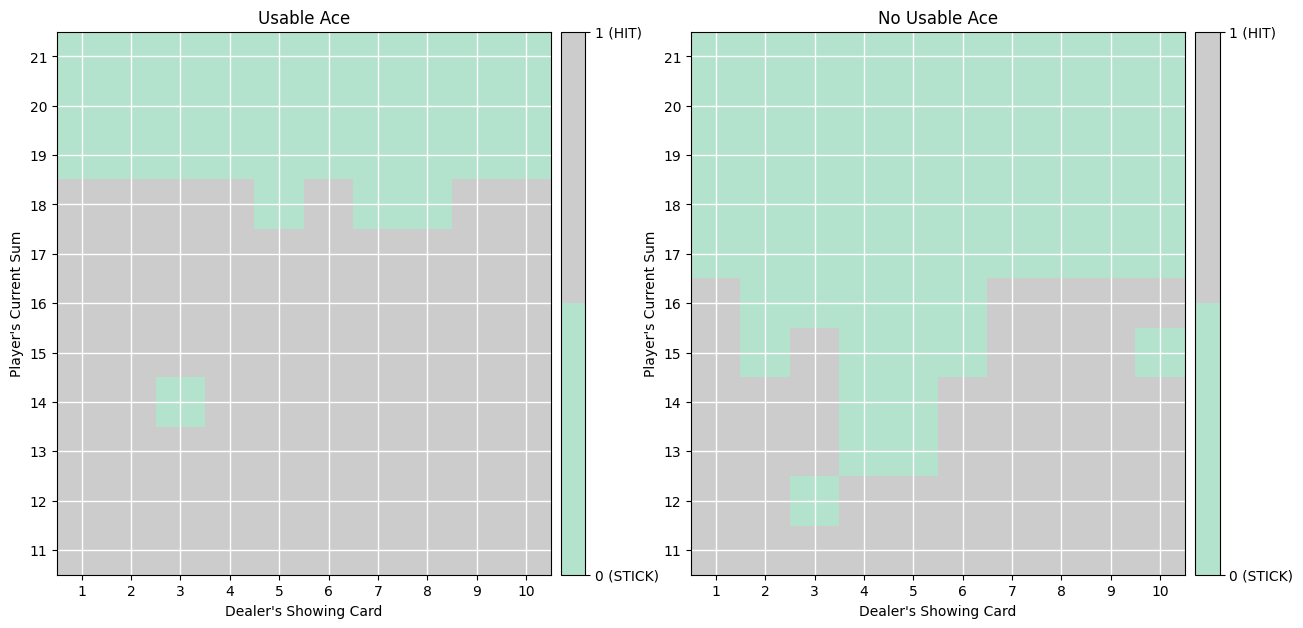

In [36]:
# plot the policy
plot_policy(policy)

### TD Control: Expected SARSA

#### Idea

- **Expected SARSA Overview**:
  - Expected SARSA modifies the update step by replacing the maximum action value with the **expected value** of the next state-action pair.
  - The expectation accounts for the **probability distribution** of selecting each possible action under the current policy:
    $$
    Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha \left[ R_{t+1} + \gamma \sum_{a \in A(s)} \pi(a|S_{t+1}) Q(S_{t+1}, a) - Q(S_t, A_t) \right]
    $$
  - Here, $\pi(a|S_{t+1})$ represents the probability of choosing action $a$ in state $S_{t+1}$ under the current policy.


- **Key Difference Between SARSA-Max and Expected SARSA**:
  - **SARSA-Max**: Uses the **greedy action** (maximum Q-value) for the next state in the update step.
  - **Expected SARSA**: Uses the **expected value** over all possible actions, weighted by their selection probabilities under the current policy.


- **Advantages of Expected SARSA**:
  - Expected SARSA is more stable than SARSA-Max because it considers the entire action space instead of relying solely on the greedy action.
  - It is less sensitive to sudden changes in Q-values caused by greedy action selection.

![](./images/expected-sarsa.png)


#### Psedocode

> note: we refer $R_{t}$ as $R_{t+1}$ current reward based $S_t$ and $A_t$, just for name convention, so slightly different with below's define.

![](./images/expected-sarsa-psedocode.png)


#### Implementation

In [37]:
def td_control_expected_sarsa(env, num_episodes, alpha, gamma=1.0, eps_decay=0.999, eps_min=0.05):
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = 1.0
    
    for i_episode in range(1, num_episodes+1):
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
            
        epsilon = max(epsilon*eps_decay, eps_min)
        
        # observe S_0
        state, info = env.reset()
        
        # in an episode
        while True:
            # choose action A_t using policy derived from Q table
            # S_t   --> A_t
            probs = epsilon_greedy(Q[state], epsilon)
            action = np.random.choice(np.arange(nA), p=probs)

            # take action A_t and observe R_t, S_t+1
            # A_t   --> R_t, S_t+1, 
            next_state, reward, done, truncated, info = env.step(action)

            # until next_state is terminal
            # reward R_T as final return
            if done:
                Q[state][action] = Q[state][action] + alpha * (reward - Q[state][action])
                break
            
            # calculate the expected action value for the next state
            # S_t+1 --> A_t+1 using same policy
            next_probs = epsilon_greedy(Q[next_state], epsilon)
            expection = np.dot(next_probs, Q[next_state])

            # update Q table
            G_estimate = reward + gamma * expection
            Q[state][action] = Q[state][action] + alpha * (G_estimate - Q[state][action])

            # update state only
            state = next_state

    # get policy
    policy = {k: np.argmax(v) for k, v in Q.items()}
    return policy, Q

In [38]:
# obtain the estimated optimal policy and action-value function
policy, Q = td_control_expected_sarsa(env, 500000, alpha=0.02, eps_min=0.05)

Episode 500000/500000.

#### Plot

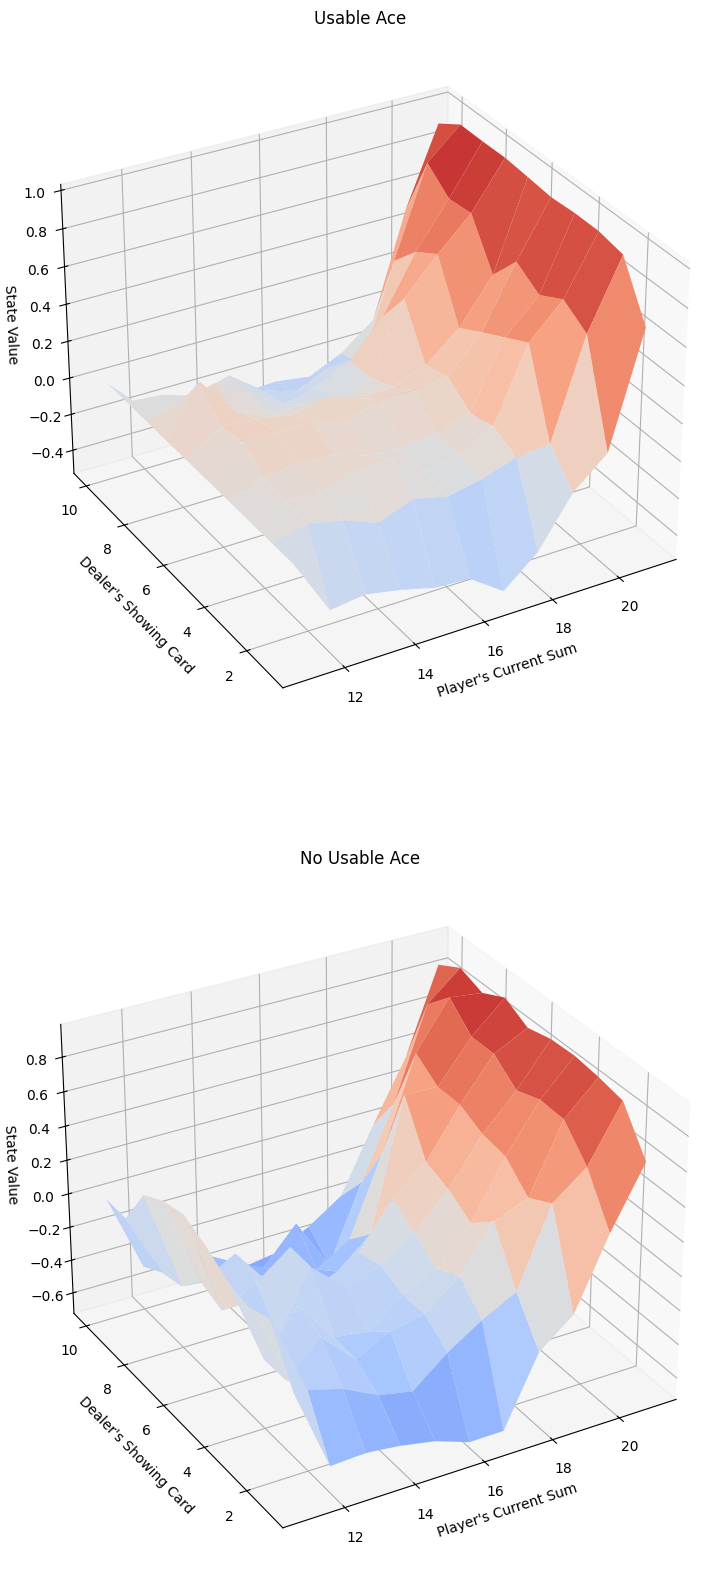

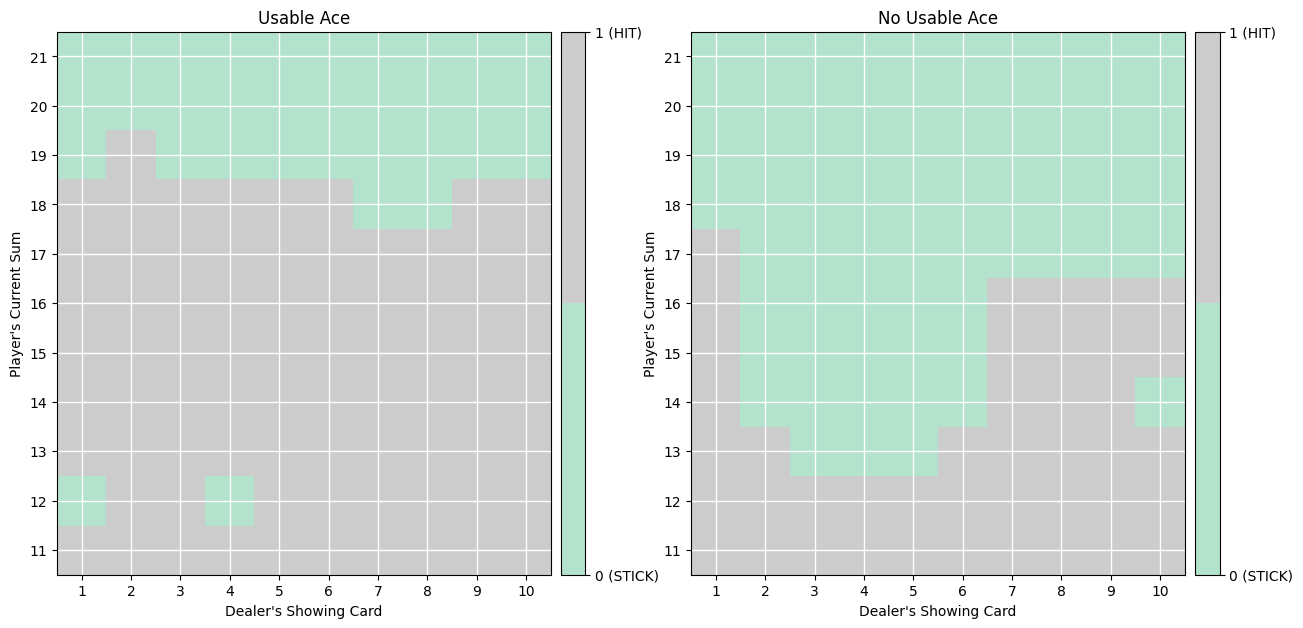

In [39]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

# plot the policy
plot_policy(policy)

### Discussion

All of the TD control algorithms we have examined (**Sarsa**, **Sarsamax**, **Expected Sarsa**) are guaranteed to converge to the optimal action-value function $ q^* $, as long as the step-size parameter $ \alpha $ is sufficiently small, and the **GLIE** conditions are met.

Once we have a good estimate for $ q^* $, a corresponding optimal policy $ \pi^* $ can then be quickly obtained by setting:

$$
\pi^*(s) = \arg\max_{a \in A(s)} q^*(s, a)
\text{for all } s \in S
$$

**Optimism**

For any TD control method, we must begin by initializing the values in the Q-table. It has been shown that initializing the estimates to large values [can improve performance](https://www.cs.cmu.edu/~bziebart/www-pub/efficient-learning-rl.pdf). 

For instance, if all of the possible rewards that can be received by the agent are negative, then initializing every estimate in the Q-table to zeros is a good technique. In this case, we refer to the initialized Q-table as **optimistic**, since the action-value estimates are guaranteed to be larger than the true action values. see below code :

```python
# Calculate beta_T
# Assuming a fixed alpha, T corresponds to num_episodes
beta_T = (1 - alpha) ** num_episodes

# Estimate V_max
# In most environments, this can be estimated based on the reward range
# Assuming the maximum reward per step is 1, use the geometric series sum as an estimate
V_max = 1 / (1 - gamma)  # If gamma=1, a reasonable upper limit should be set

# Initialize the Q-table
# Use defaultdict but modify the default value calculation
initial_value = V_max / beta_T
Q = defaultdict(lambda: np.ones(nA) * initial_value)

```